In [1]:
# %load 2comp_sed.py
#!/usr/bin/env python

### 1D sedimentation simulation

Solve a one-dimensional polydisperse sedimentation problem


$\rho_t + (f(\rho))_x = 0 $

Here $\rho$ is a vector of volume fractions $\in[0,1]$. f is a user-specified function
for the flux of particles.


In [2]:
from __future__ import absolute_import
from clawpack import riemann
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# boundary conditions
def lowerwall(state,dim,t,qbc,auxbc,num_ghost):
    for i in range(num_ghost):
        qbc[:,i,...] = -qbc[:,2*num_ghost-1-i,...]

def upperwall(state,dim,t,qbc,auxbc,num_ghost):
    for i in range(num_ghost):
#         print(i)
#         print(qbc[:,-i-1,...])
#         print(-qbc[:,-2*num_ghost+i,...])
        
        qbc[:,-i-1,...] = -qbc[:,-2*num_ghost+i,...]
#         print(qbc[:,-i-1,...])
        
# test2d = np.arange(12).reshape((2,-1))
# print(test2d)
# print(upperwall(0,0,0,test2d,0,2))

def lowerdirichlet(state,dim,t,qbc,auxbc,num_ghost):
    nspecies = qbc.shape[0]
    bvals = np.array([0.,0.])
    for i in range(num_ghost):
        qbc[:,i] = bvals

def upperdirichlet(state,dim,t,qbc,auxbc,num_ghost):
    nspecies = qbc.shape[0]
    bvals = np.array([-0.4,-0.1])
    for i in range(num_ghost):
        qbc[:,-i-1] = bvals

In [4]:
def qinit(state,x0,u_rel,IC='dam-break'):
    xc = state.grid.x.centers

In [10]:
def runsim(qinit=None,num_output_times=10,tfinal=1,mx=51,IC='dam-break',
    use_petsc=False,kernel_language='Python',outdir='./_output',solver_type='classic'):

    if use_petsc:
        import clawpack.petclaw as pyclaw
    else:
        from clawpack import pyclaw

    if kernel_language == 'Python':
        rs = riemann.advection_nonlinear_1D_py.advection_nonlinear_1D
    elif kernel_language == 'Fortran':
        print('No fortran solver available for advection_nonlinear_1D')
        pass

    if solver_type == 'classic':
        solver = pyclaw.ClawSolver1D(rs)
        solver.limiters = pyclaw.limiters.tvd.vanleer
    elif solver_type == 'sharpclaw':
        solver = pyclaw.SharpClawSolver1D(rs)

    solver.kernel_language = kernel_language

    solver.bc_lower[0] = pyclaw.BC.custom
    solver.bc_upper[0] = pyclaw.BC.custom
    
    solver.user_bc_lower = lowerdirichlet
    solver.user_bc_upper = upperwall

    xlower = 0.0
    xupper = 1.0
    mx = mx  # from kwargs
    x = pyclaw.Dimension(xlower,xupper,mx,name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 2
    state = pyclaw.State(domain,num_eqn)

    # Gravitational constant
    state.problem_data['u_rel'] = np.array([1.,1/30.])
    state.problem_data['efix'] = False

    xc = state.grid.x.centers

#     IC = 'dam-break'
#     IC = 'uniform-all'
#     IC = 'perturbation'
#     x0 = 0.25
    print(xc)
    if IC=='uniform-all':
        c0 = np.array([0.2,0.1])
        # state defaults to empty. Convert to ones and fill with c0
        state.q = np.ones_like(state.q)*c0[:,np.newaxis]

    elif IC=='dam-break':
        # I changed state.is_valid() to always return true for fortran contiguity
        x0 = 0.7
        cr0 = np.array([0.1,0.1])
        cl0 = np.array([0.,0.])
        state.q = np.ones_like(state.q)
        state.q = cl0[:,np.newaxis]*(xc <= x0)[np.newaxis,:] + \
                  cr0[:,np.newaxis]*(xc >  x0)[np.newaxis,:]

    elif IC=='perturbation':
        x1 = 0.3
        x2 = 0.7
        eps = 0.15
        state.q[0,:] = eps*np.exp(-1/eps*(xc-x1)**2)
        state.q[1,:] = eps*np.exp(-1/eps*(xc-x2)**2)
    
    claw = pyclaw.Controller()
    claw.keep_copy = True
    claw.num_output_times = num_output_times
    claw.tfinal = tfinal
    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.outdir = outdir
    
    return claw

In [11]:
# %%capture
ntimes = 30
mx = 10
tfinal = 3
claw = runsim(num_output_times=ntimes,tfinal=tfinal,mx=mx,
              IC='dam-break')
claw.run()

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
ascii
2019-02-28 12:55:43,169 INFO CLAW: Solution 0 computed for time t=0.000000
q_ave at interface
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.05  0.1   0.1  -0.1
  -0.1 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.05  0.1   0.1  -0.1
  -0.1 ]]
amdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.55700413e-04  0.00000000e+00  0.00000000e+00  4.07049692e-01
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.96551746e-03  0.00000000e+00  0.00000000e+00  1.55740813e-03
   0.00000000e+00]]
apdq
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.06435554  0.          0.         -0.40704969
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.

q_ave at interface
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.02951402e-05
   4.16324803e-03  3.96922733e-02  5.66638351e-02 -5.66638351e-02
  -5.66638351e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  5.71987326e-04
   4.71789085e-02  9.49061848e-02  8.71168450e-02 -8.71168450e-02
  -8.71168450e-02]]
amdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  5.37396391e-06 -8.02832543e-05  1.37517686e-01
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -5.12286760e-05  5.09429263e-04  8.03689613e-03
   0.00000000e+00]]
apdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  

q_ave at interface
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.61723052e-08
   4.72457643e-08  6.85626861e-04  8.10826863e-04 -8.10826863e-04
  -8.10826863e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  4.54108239e-04
   4.25504872e-02  8.67508809e-02  7.28818052e-02 -7.28818052e-02
  -7.28818052e-02]]
amdq
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.00059191
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.00565905
  0.        ]]
apdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.23137317e-08
   1.45654332e-07  1.14011573e-03 -9.57820685e-04 -5.91914790e-04
  -1.30594905e-03]
 [ 0.00000000e+00  0.00000000e+00 

q_ave at interface
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.37317412e-11
   1.77138452e-09  2.97391834e-06 -2.79956100e-06  2.79956100e-06
   2.79956100e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  3.58088060e-04
   3.81207440e-02  8.23161650e-02  6.70010392e-02 -6.70010392e-02
  -6.70010392e-02]]
amdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.64393920e-05
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  4.32239492e-03
   0.00000000e+00]]
apdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  

/home/ubuntu/miniconda3/lib/python3.6/site-packages/clawpack/riemann/advection_nonlinear_1D_py.py:72: RuntimeWarning: invalid value encountered in true_divide
  J  = (J1-J0)/dx


q_ave at interface
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.71934821e-13
   1.16653588e-10  8.75916157e-08 -1.63412625e-06  1.63412625e-06
   1.63412625e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  3.17583215e-04
   3.59373192e-02  8.01215830e-02  6.51239578e-02 -6.51239578e-02
  -6.51239578e-02]]
amdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.86274146e-06
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  3.93240591e-03
   0.00000000e+00]]
apdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  

q_ave at interface
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.47961032e-16
   1.02210814e-13  3.73398235e-11 -1.30162291e-07  1.30162291e-07
   1.30162291e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.49185566e-04
   3.16790834e-02  7.57240987e-02  6.24775478e-02 -6.24775478e-02
  -6.24775478e-02]]
amdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.91430105e-07
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  3.42085471e-03
   0.00000000e+00]]
apdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  

q_ave at interface
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.30747456e-20
  -2.97748408e-17 -2.28748550e-14 -1.12902919e-08  1.12902919e-08
   1.12902919e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.94896566e-04
   2.76228541e-02  7.13286703e-02  6.06187461e-02 -6.06187461e-02
  -6.06187461e-02]]
amdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.10795414e-08
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  3.11551976e-03
   0.00000000e+00]]
apdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  

2019-02-28 12:55:43,511 INFO CLAW: Solution 24 computed for time t=2.400000
q_ave at interface
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.41286378e-25
  -1.35169706e-20 -7.89318981e-18 -1.09453543e-09  1.09453543e-09
   1.09453543e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.51973988e-04
   2.38287332e-02  6.69544668e-02  5.90665193e-02 -5.90665193e-02
  -5.90665193e-02]]
amdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.93002048e-09
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.91908412e-03
   0.00000000e+00]]
apdq
[[ 0.00000000e+00  0.0000

q_ave at interface
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.26166630e-27
  -4.24259920e-23 -1.10904893e-20  2.01355741e-10 -2.01355741e-10
  -2.01355741e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.25872237e-04
   2.11835272e-02  6.37005713e-02  5.79372678e-02 -5.79372678e-02
  -5.79372678e-02]]
amdq
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 9.04331000e-10
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.81133034e-03
  0.00000000e+00]]
apdq
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.52266460

{'cflmax': 0.9916607227860634,
 'dtmin': 0.04446132518501377,
 'dtmax': 0.08037733281688765,
 'numsteps': 62}

(10, 62)


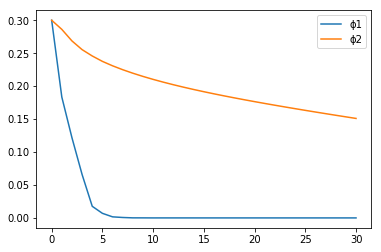

In [12]:
result = np.vstack([frame.q for frame in claw.frames]).T
print(result.shape)
plt.plot(np.sum(result[:,0::2],axis=0))
plt.plot(np.sum(result[:,1::2],axis=0))
plt.legend(['ϕ1','ϕ2'])

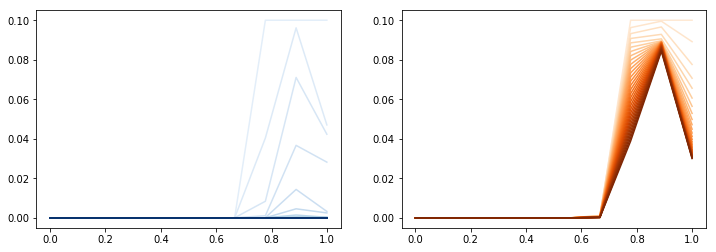

In [13]:
xs = np.linspace(0,1,mx)
color1 = iter(plt.get_cmap('Blues')(np.linspace(0.1,1,ntimes)))
color2 = iter(plt.get_cmap('Oranges')(np.linspace(0.1,1,ntimes)))

fig,ax = plt.subplots(ncols=2,figsize=(12,4))
for j,color in enumerate((color1,color2)):
    for i in range(ntimes):
        ax[j].plot(xs,result[:,j+2*i],color=next(color))

2019-02-28 12:55:25,388 INFO CLAW: Animation.save using <class 'clawpack.visclaw.JSAnimation.html_writer.HTMLWriter'>



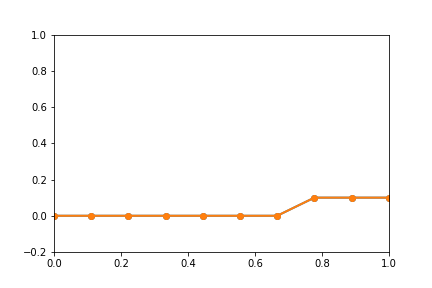
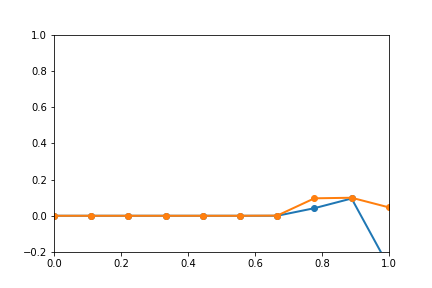
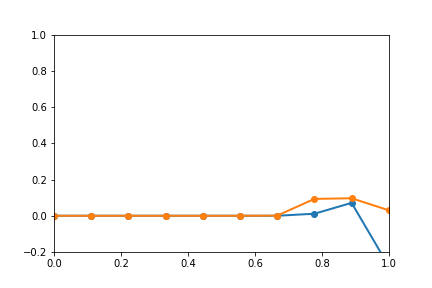
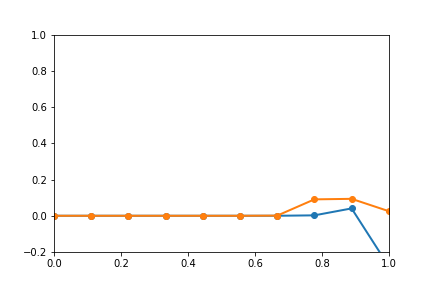
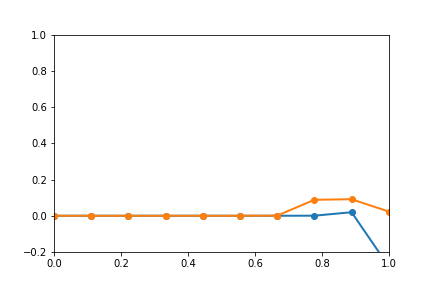
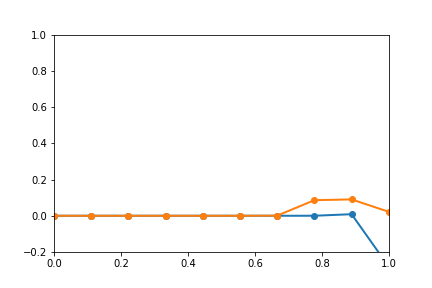
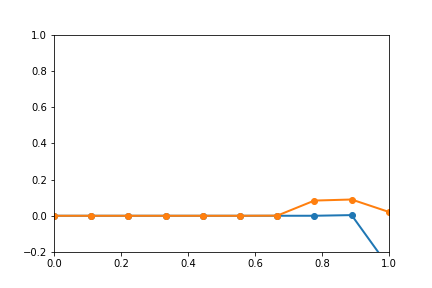
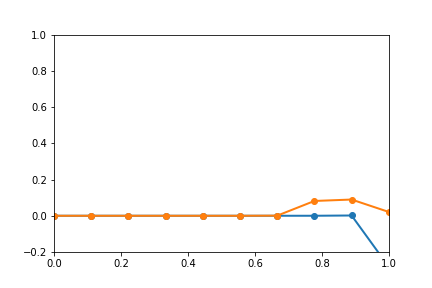
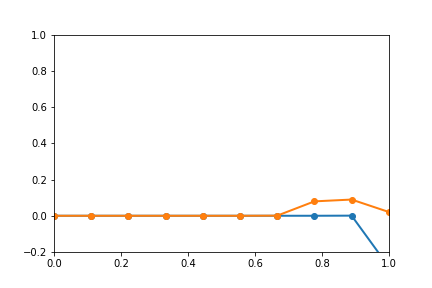
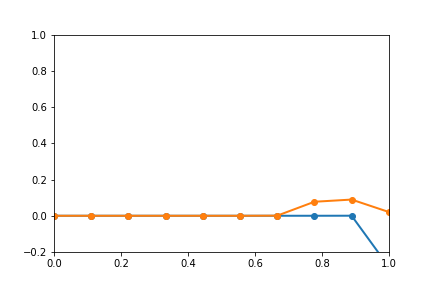
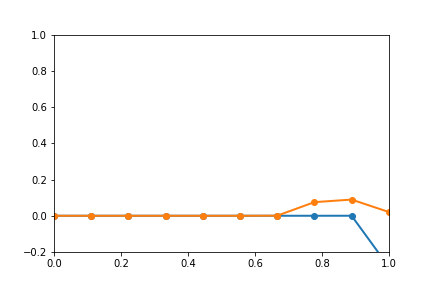
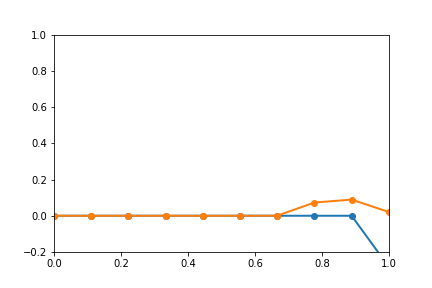
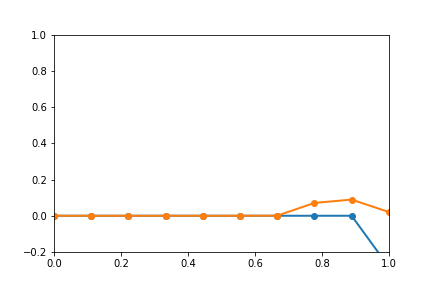
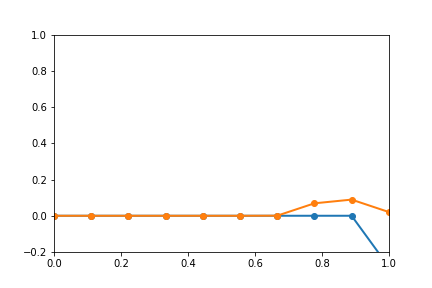
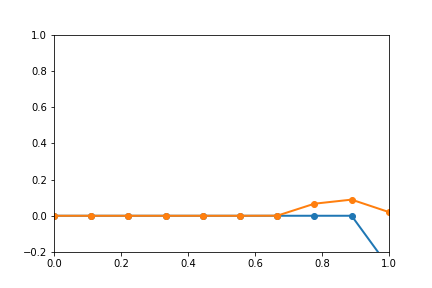
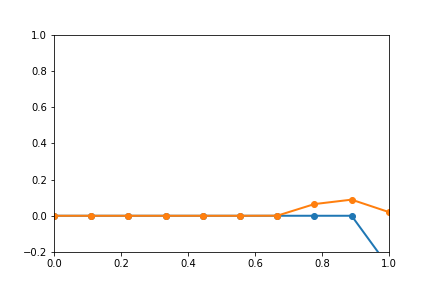
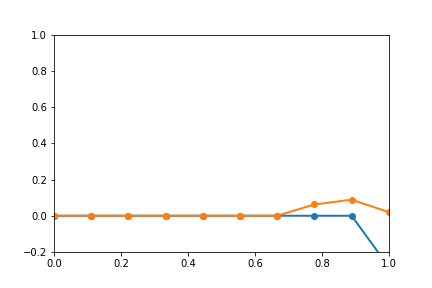
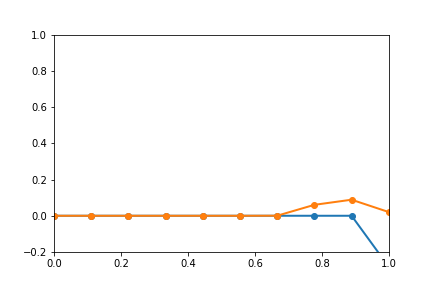
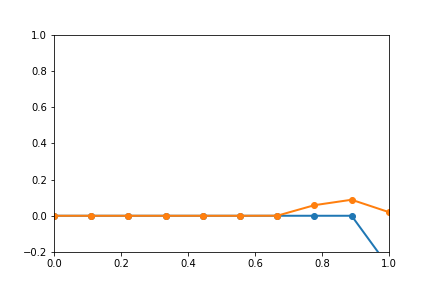
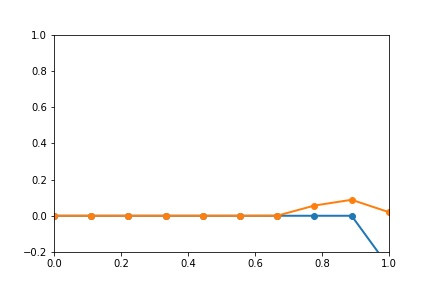
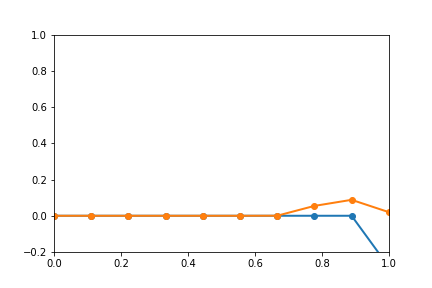
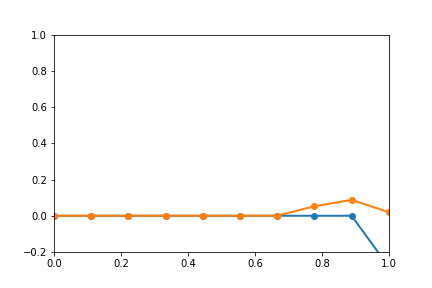
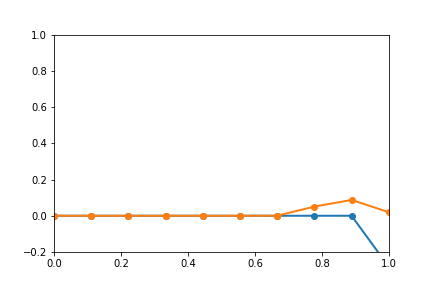
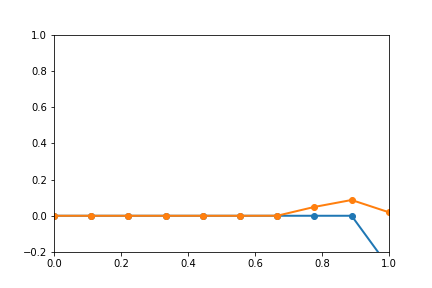
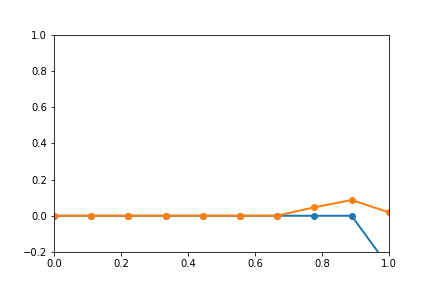
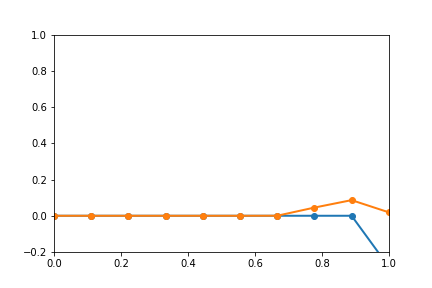
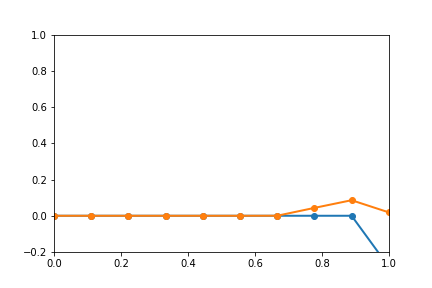
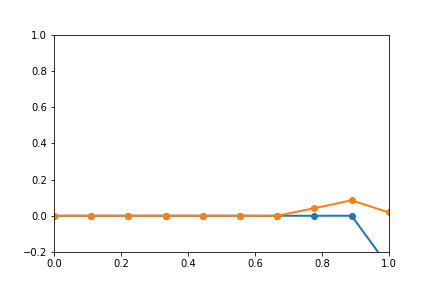
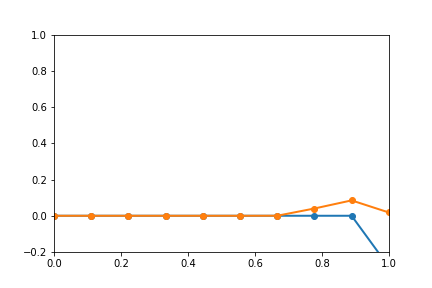
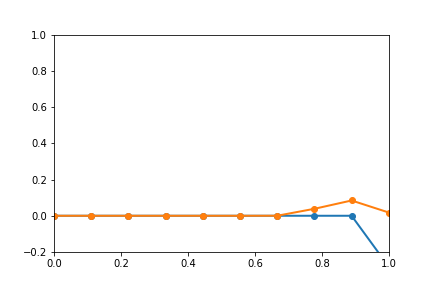
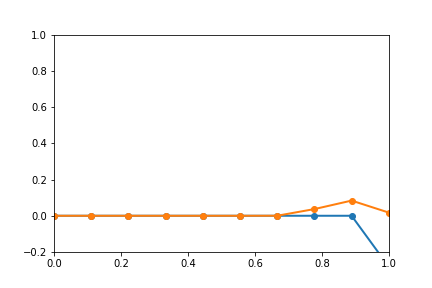

In [9]:
from matplotlib import animation
import matplotlib.pyplot as plt
from clawpack.visclaw.JSAnimation import IPython_display
import numpy as np

# x=domain.grid.x.centers
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-0.2, 1.0))

frame = claw.frames[0]
# species1 = frame.q[0,:]
line1, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], 'o-', lw=2)

def fplot(frame_number):
    frame = claw.frames[frame_number]
    species1 = frame.q[0,:]
    species2 = frame.q[1,:]
    line1.set_data(xs,species1)
    line2.set_data(xs,species2)
    return line1,line2

animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=250)